In [1]:
from glob import glob 
import re
import numpy as np
from math import pi, sqrt
from decimal import Decimal
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import argparse, sys

%matplotlib notebook

In [30]:
class FreqNM:
    
    """
    Class used to calculate frequencies of stretch and bend normal modes of
    molecules HXH from energies calculations using SCF
    
    Example usage:
    
    Freq_NM(<path to folder>) -- initialise class and compute normal mode frequencies
    print(<class instance>) -- print normal mode frequencies
    <class instance>.plot() -- plot 3D energy surface
    <class instance>.freqr -- frequency of stretch normal mode
    <class instance>.freqtheta -- frequency of bend normal mode
    
    """
    
    expected_freq = {'H2O': {'freqr': 3657, 'freqtheta': 1594},
                     'H2S': {'freqr': 2615, 'freqtheta': 1183}}
    
    def __init__(self, path):
        """
        Get data from text files into a numpy array and process
        """
        self.name = re.search(r'(\w+)outfiles', path).group(1)
        numfiles = len(glob('%s/*.out' % path))
        self.data = np.zeros((numfiles, 3))
    
        get_params = re.compile('r(\d+\.?\d+)theta(\d+\.?\d+)')
        get_energy = re.compile('E\(\w+\)\s+=\s+([-+]?\d+\.?\d+)')

        for i, doc in enumerate(glob('%s/*.out' % path)):
            params = re.search(get_params, doc)
            r = params.group(1)
            theta = params.group(2)
            with open(doc, 'r') as idoc:
                text = idoc.read()
                [match] = re.finditer(get_energy, text)
                energy = match.group(1)
            self.data[i] = [r, theta, energy]
        
        self._get_nmfreq()
            
    def _get_nmfreq(self):
        """
        Calculate normal mode frequencies
        """
        num_consider = 5 # number of points arount the minimum to fit a parabola to
        
        data = self.data
        hartree_to_J = 4.35974*10**(-18)
        NA = 6.02214086*10**(23)
        c_tilde = 29979245800.
    
        minindex = np.argmin(data[:,2])
        [minr, mintheta, minenergy] = data[minindex].squeeze()
        
        dataminr = data[np.where(data[:,1]==mintheta)]
        dataminr = np.array(sorted(dataminr, \
                                   key=lambda row: np.abs(row[0]-minr)))
        dataminr=dataminr[:num_consider]
        p = np.polyfit((dataminr[:,0]-minr)**2, dataminr[:,2], 1)
        # using formulae from the handout
        kr = p[0]*2*hartree_to_J/(10**(-10*2)) # units Hartree*m^-2
        mu1 = 2*10**(-3)/NA
        self.freqr = 1/(2*pi*c_tilde)*sqrt(kr/mu1)
        
        datamintheta = data[np.where(data[:,0]==minr)]
        datamintheta = np.array(sorted(datamintheta, \
                                       key=lambda row: np.abs(row[1]-mintheta)))
        datamintheta = datamintheta[:num_consider]
        p = np.polyfit((datamintheta[:,1]-mintheta)**2, datamintheta[:,2], 1)
        # using formulae from the handout
        ktheta = p[0]*2*hartree_to_J*(180/pi)**2 # units Hartree*radians^-2
        mu2 = 0.5*10**(-3)/NA
        self.freqtheta = 1/(2*pi*c_tilde)*sqrt(ktheta/(mu2*(minr*10**(-10))**2))
        
        self.minr = minr
        self.mintheta = mintheta
        self.minenergy = minenergy
    
    
    def plot(self):
        """
        Plot the energy surface
        """
        xunique = len(np.unique(self.data[:,0]))
        yunique = len(np.unique(self.data[:,1]))

        x_changes_first = len(np.unique(self.data[0:xunique,0])) == xunique
        if x_changes_first:
            shape = (yunique, xunique)
        else:
            shape = (xunique, yunique)

        X = self.data[:,0].reshape(shape)
        Y = self.data[:,1].reshape(shape)
        Z = self.data[:,2].reshape(shape)
        fig = plt.figure(figsize=(8.5,8.5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
        ax.set_xlabel(u'r / \u212B')
        ax.set_ylabel(u'\u0398 / degrees')
        ax.set_zlabel(u'Energy / hartree')
        ax.set_title('Energy surface for %s' % self.name) 
        
    def __str__(self):
        message = str()
        message += u'\nMolecule: %s\n\n' % self.name
        message += 'Vibr freq of stretching mode = %.0f cm-1\n' % self.freqr
        message += 'Vibr freq of  bending mode = %.0f cm-1\n' % self.freqtheta
        try:
            message += 'Expected vibr freq of stretching mode = %.0f cm-1\n' % FreqNM.expected_freq[self.name]['freqr']
            message += 'Expected vibr freq of bending mode = %.0f cm-1\n\n' % FreqNM.expected_freq[self.name]['freqtheta']
        except:
            message += '\n'
        message += 'Equilibrium energy = %.2f Hartree\n' % self.minenergy
        message += u'Equilibrium angle = %.0f\u00B0\n' % self.mintheta
        message += u'Equilibrium bond length = %0.2f \u212B' % self.minr
        return message.encode('utf-8') 
    
    def __repr__(self):
        return 'normal modes of %s' % self.name


Molecule: H2O

Vibr freq of stretching mode = 4044 cm-1
Vibr freq of  bending mode = 1712 cm-1
Expected vibr freq of stretching mode = 3657 cm-1
Expected vibr freq of bending mode = 1594 cm-1

Equilibrium energy = -76.02 Hartree
Equilibrium angle = 105°
Equilibrium bond length = 0.95 Å


<IPython.core.display.Javascript object>


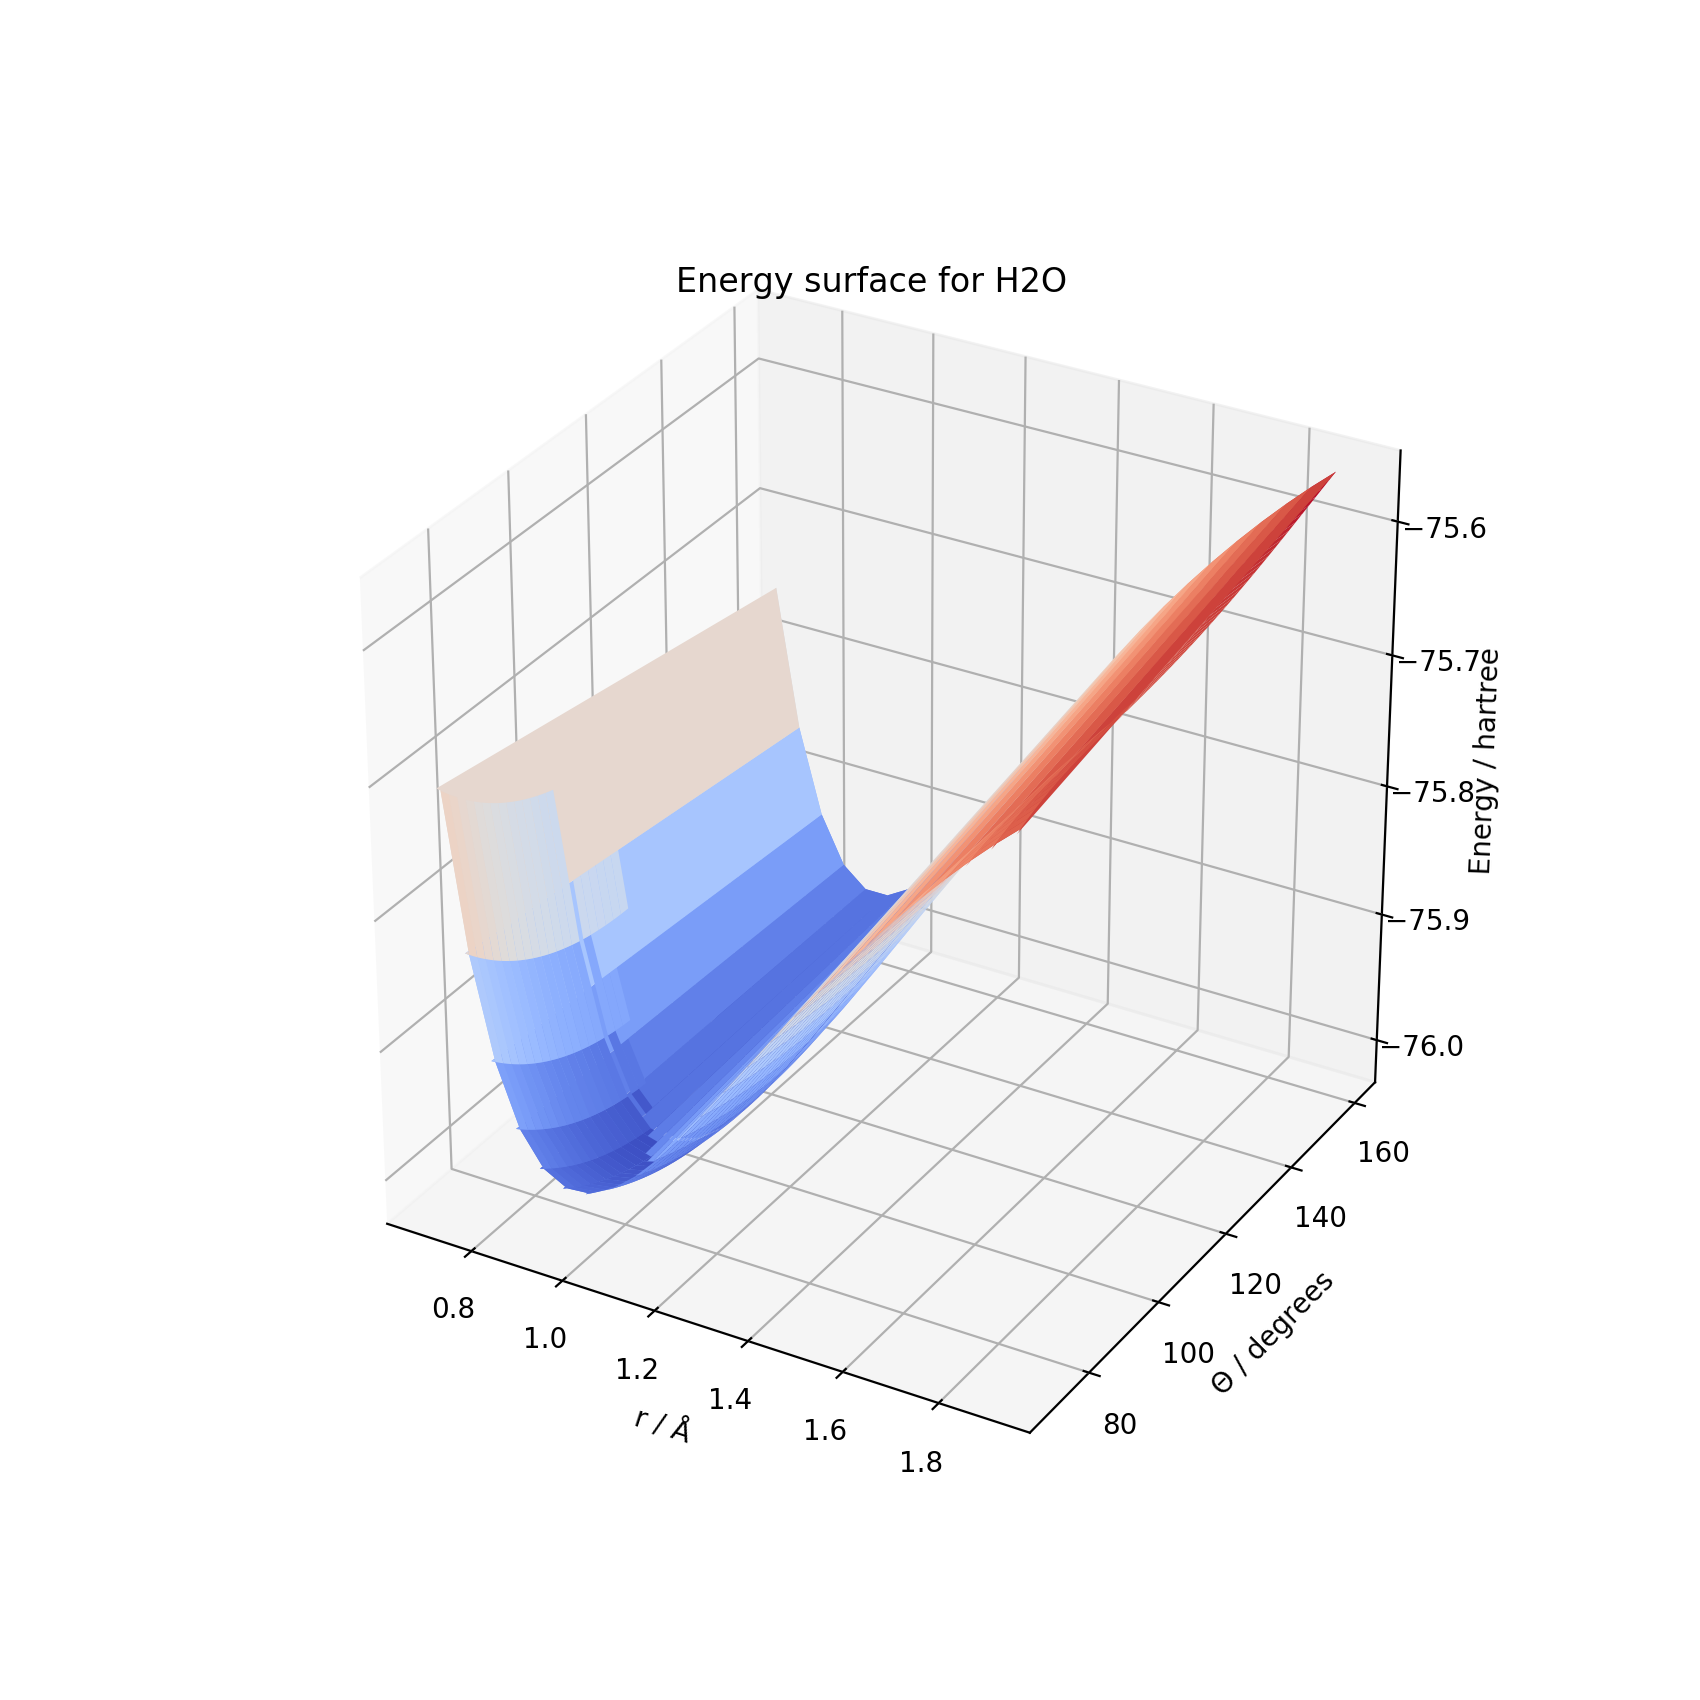


Molecule: H2S

Vibr freq of stretching mode = 2734 cm-1
Vibr freq of  bending mode = 1280 cm-1
Expected vibr freq of stretching mode = 2615 cm-1
Expected vibr freq of bending mode = 1183 cm-1

Equilibrium energy = -398.68 Hartree
Equilibrium angle = 94°
Equilibrium bond length = 1.35 Å


<IPython.core.display.Javascript object>


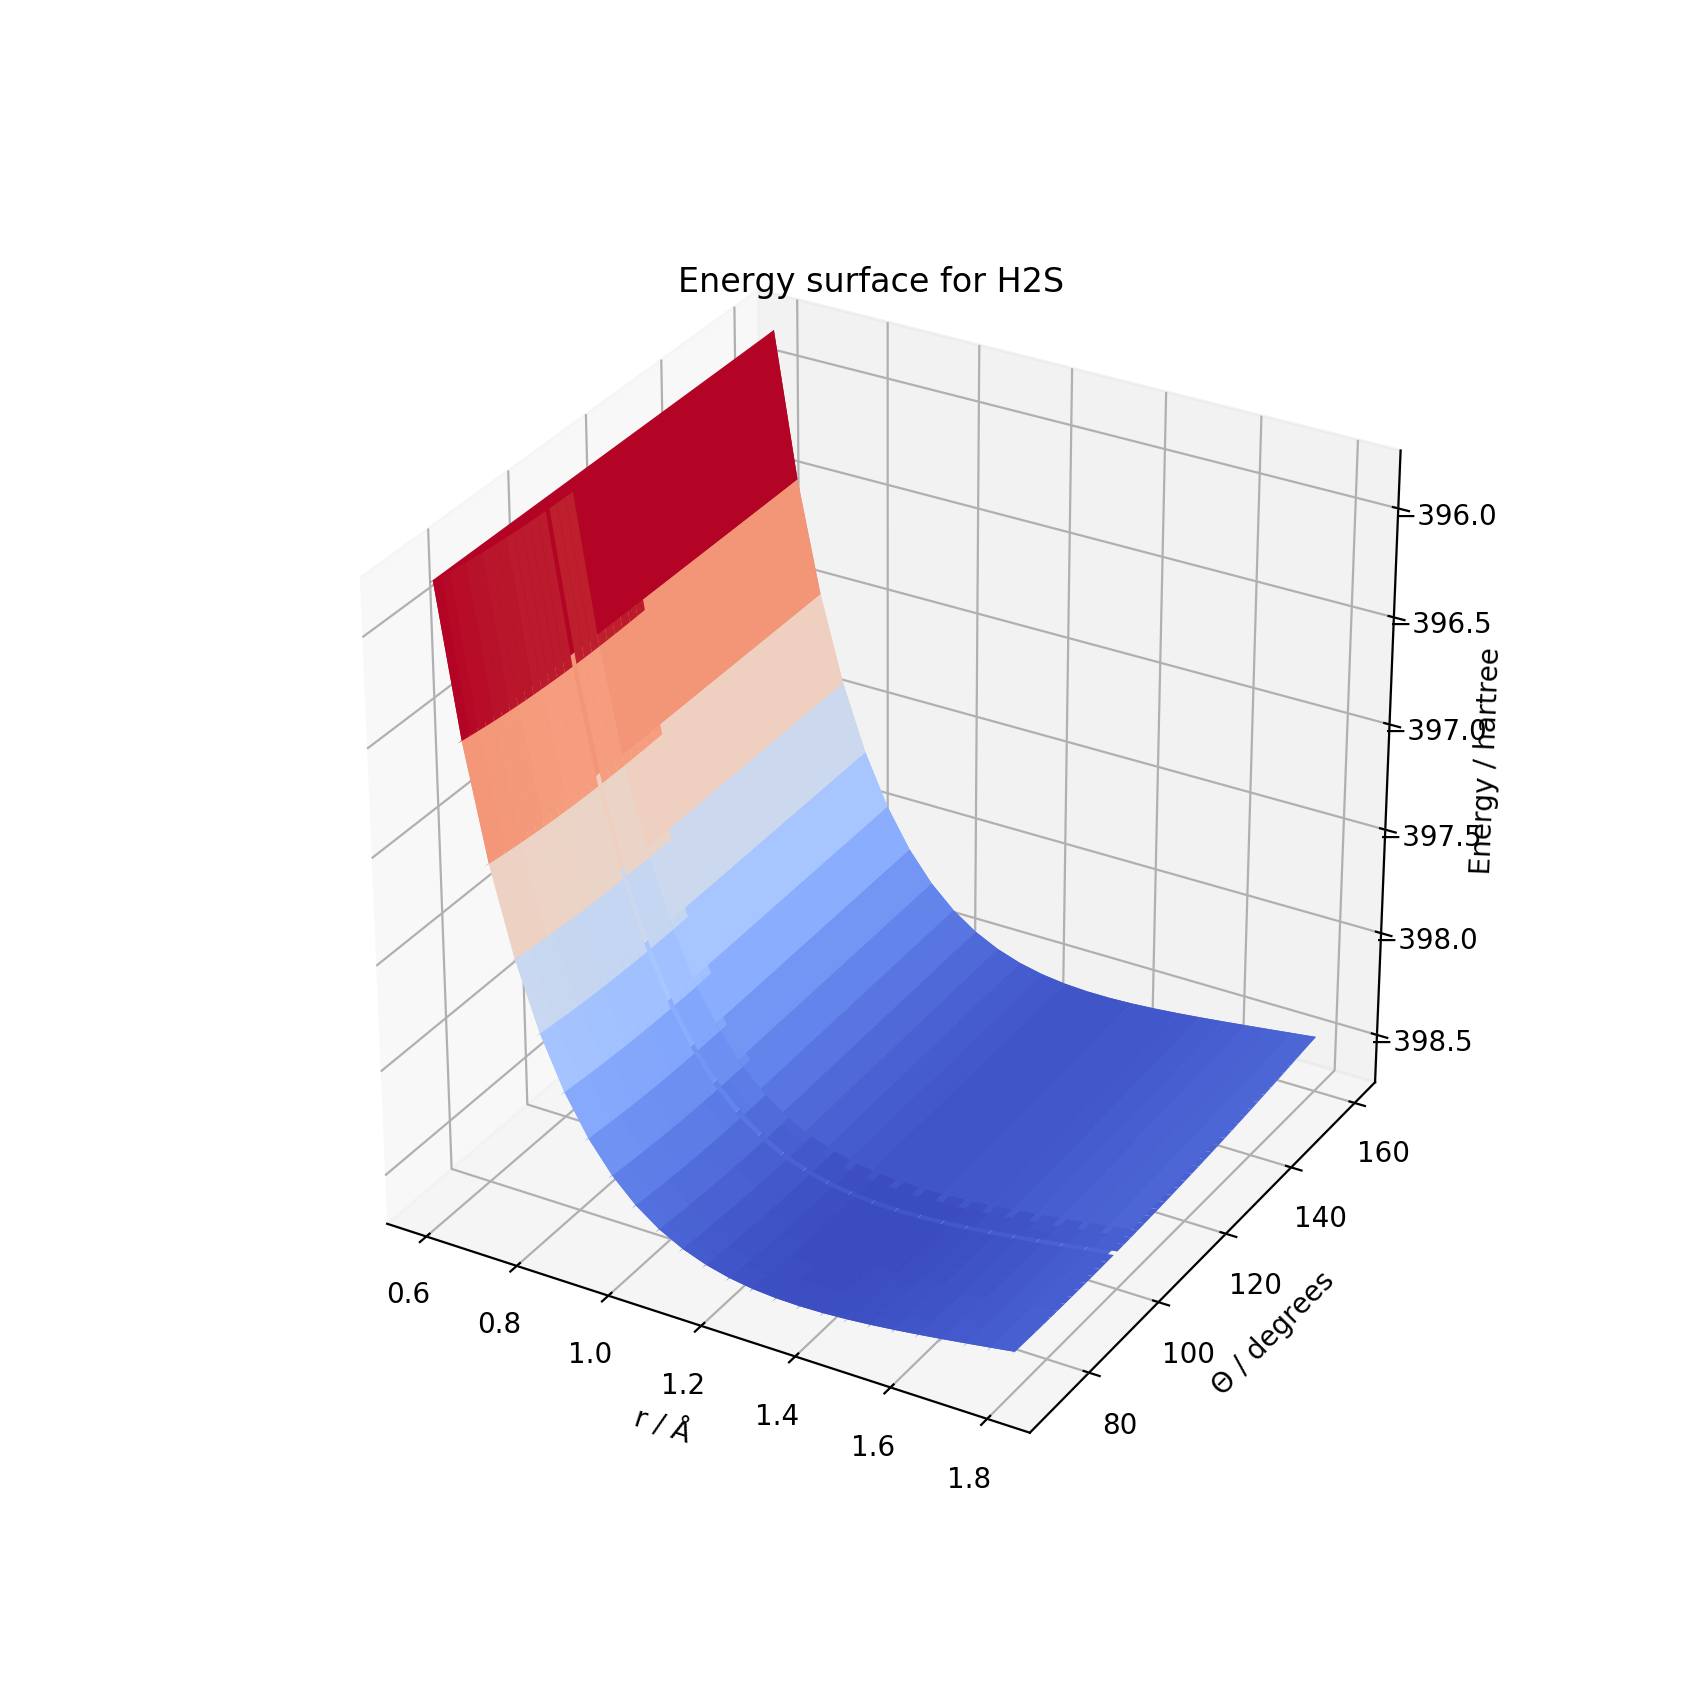

In [31]:
FOLDER1 = '/Users/alexmayorov/Downloads/Ex2 Files-20171213/H2Ooutfiles'
FOLDER2 = '/Users/alexmayorov/Downloads/Ex2 Files-20171213/H2Soutfiles'
folders = [FOLDER1, FOLDER2]
for folder in folders:
    instance = FreqNM(folder)
    print(instance)
    instance.plot()